In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Please update the file path for the tradelog data. Download data from https://www.asxenergy.com.au/tradelog.
file_path = r'C:\Users\wwang2\OneDrive - ACCC\Desktop\Grad\R4_AER_EPR\Analysing price and volume trends in ASX energy contracts\trades.csv'

In [3]:
# Please update the selections for contract type, region, expiry time, year and etc for the analysis to be performed.
contract = 'Base'
state = 'NSW'
expiries = ['Q1', 'Q2', 'Q3', 'Q4']
years = [2022, 2023, 2024, 2025, 2026]

In [4]:
# Define the mappings from the ASX electricity contract cheat sheet
contract_codes = {
    'B': 'Base', 'P': 'Peak', 'G': 'Cap', # $300 cap
    'H': 'Base strip', 'D': 'Peak strip', 'R': 'Cap strip'
}

region_codes = {
    'N': 'NSW', 'Q': 'QLD', 'V': 'VIC', 'S': 'SA'
}

expiry_month_codes = {
    'F': 'JAN', 'G': 'FEB', 'H': 'MAR', 'J': 'APR', 
    'K': 'MAY', 'M': 'JUN', 'N': 'JUL', 'Q': 'AUG', 
    'U': 'SEP', 'V': 'OCT', 'X': 'NOV', 'Z': 'DEC'
}

quarter_codes = {
    'H': 'Q1', 'M': 'Q2', 'U': 'Q3', 'Z': 'Q4'
}

In [5]:
# Function to decode the product code to plain English
def decode(code):
    match = re.match(r'([A-Z])([A-Z])([A-Z])(\d{4})([A-Z]?)(\d{7})?', code)
    
    if match:
        contract = contract_codes.get(match.group(1), '')
        region = region_codes.get(match.group(2), '')
        expiry = quarter_codes.get(match.group(3), '')
        year = match.group(4)
        option_type = match.group(5)
        strike_price = match.group(6)
        
        if option_type == "F":
            return f"{contract} {region} {expiry} {year}"
        elif option_type in ["C", "P"]:
            option = "Call option" if option_type == "C" else "Put option"
            strike_price_dollars = f"${int(strike_price) / 100:.2f}"
            return f"{contract} {region} {expiry} {year} {option} with a strike price of {strike_price_dollars}"
    
    return "Invalid code"

In [6]:
# Function to encode plain English to product code
def encode(plain_english):
    parts = plain_english.split()
    
    if len(parts) == 4:
        contract_code = list(contract_codes.keys())[list(contract_codes.values()).index(parts[0])]
        region_code = list(region_codes.keys())[list(region_codes.values()).index(parts[1])]
        expiry_code = list(quarter_codes.keys())[list(quarter_codes.values()).index(parts[2])]
        year_code = parts[3]
        
        return f"{contract_code}{region_code}{expiry_code}{year_code}F"\
    
    elif len(parts) == 8:
        contarct_code = list(contract_codes.keys())[list(contract_codes.values()).index(parts[0])]
        region_code = list(region_codes.keys())[list(region_codes.values()).index(parts[1])]
        expiry_code = list(quarter_codes.keys())[list(quarter_codes.values()).index(parts[2])]
        year_code = parts[3]
        option_type = "C" if parts[4] == "Call" else "P"
        strike_price_cents = f"{int(float(parts[-1][1:]) * 100):07d}"
        
        return f"{contract_code}{region_code}{expiry_code}{year_code}{option_type}{strike_price_cents}"
    
    return "Invalid input"

In [7]:
# Example usage of the above encode and decode functions
code = "BNH2022C0006000"
plain_english = "Cap QLD Q4 2025"

decoded = decode(code)
encoded = encode(plain_english)

print(f"Decoded: {decoded}")
print(f"Encoded: {encoded}")

Decoded: Base NSW Q1 2022 Call option with a strike price of $60.00
Encoded: GQZ2025F


In [8]:
def generate_trade_codes(contract, state, expiries, years):
    trade_codes = []
    for expiry in expiries:
        for year in years:
            trade_code = f"{contract} {state} {expiry} {year}"
            trade_codes.append(encode(trade_code))
    return trade_codes

trade_codes_of_interest = generate_trade_codes(contract, state, expiries, years)
print(trade_codes_of_interest)

['BNH2022F', 'BNH2023F', 'BNH2024F', 'BNH2025F', 'BNH2026F', 'BNM2022F', 'BNM2023F', 'BNM2024F', 'BNM2025F', 'BNM2026F', 'BNU2022F', 'BNU2023F', 'BNU2024F', 'BNU2025F', 'BNU2026F', 'BNZ2022F', 'BNZ2023F', 'BNZ2024F', 'BNZ2025F', 'BNZ2026F']


In [9]:
def read_trade_data(file_path):
    # Skip the first line with the separator information
    df = pd.read_csv(file_path, skiprows=1)
    df['Date'] = pd.to_datetime(df['Date'])  # Convert Date column to datetime format
    return df

In [10]:
def process_trade_data(df, trade_code):
    # Filter the dataframe by the specified trade code
    filtered_df = df[df['Code'] == trade_code]
    
    # Group by date and calculate the required sums
    grouped_df = filtered_df.groupby('Date').agg({
        'Cleared Volume': 'sum',
        'Face Value': 'sum',
        'Volume x MWh': 'sum'
    }).reset_index()
    
    # Rename the columns
    grouped_df.rename(columns={
        'Cleared Volume': 'Daily contracts traded',
        'Face Value': 'Daily dollars traded',
        'Volume x MWh': 'Daily MWh traded'
    }, inplace=True)
    
    # Calculate the daily volume weighted average price in $/MWh
    grouped_df['Daily average price'] = grouped_df['Daily dollars traded'] / grouped_df['Daily MWh traded']
    
    # Calculate the cumulative sums
    grouped_df['Cumulative MWh traded'] = grouped_df['Daily MWh traded'].cumsum()
    grouped_df['Cumulative dollars traded'] = grouped_df['Daily dollars traded'].cumsum()
    
    # Calculate the cumulative trade volume-weighted average price in $/MWh
    grouped_df['Cumulative average price'] = grouped_df['Cumulative dollars traded'] / grouped_df['Cumulative MWh traded']
    
    return grouped_df

In [11]:
def create_trade_chart(df, plain_english_name):
    # Convert Date column to datetime format if not already
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'])
    
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots(figsize=(14, 10), dpi=150)

    # Plot Daily average price and Cumulative average price on the primary vertical axis
    ax1.plot(df['Date'], df['Daily average price'], color='tab:blue', label='Daily Average Price')
    ax1.plot(df['Date'], df['Cumulative average price'], color='tab:orange', label='Cumulative Average Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Average price ($/MWh)')
    ax1.grid(True)

    # Create a secondary y-axis to plot Daily MWh traded and Cumulative MWh traded
    ax2 = ax1.twinx()
    #ax2.bar(df['Date'], df['Daily MWh traded'], color='tab:green', alpha=0.5, label='Daily MWh Traded')
    #ax2.bar(df['Date'], df['Cumulative MWh traded'], color='tab:red', alpha=0.5, label='Cumulative MWh Traded')
    ax2.plot(df['Date'], df['Daily MWh traded'], color='tab:green', linestyle='--', label='Daily MWh Traded')
    ax2.plot(df['Date'], df['Cumulative MWh traded'], color='tab:red', linestyle='--', label='Cumulative MWh Traded')
    ax2.set_ylabel('MWh traded')

    # Combine legends from both axes and place them at the bottom
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.title(plain_english_name)

    # Save the chart to the specified file path
    plt.savefig(f'results/{plain_english_name}.png')
    #plt.show()
    plt.close()

In [12]:
def plot_summary_df(summary_df, summary_chart_title):
    # Convert Date column to datetime format if not already
    #if not pd.api.types.is_datetime64_any_dtype(summary_df['Date']):
    #    summary_df['Date'] = pd.to_datetime(summary_df['Date'])
    
    # Create a figure and a set of subplots with larger and taller size
    fig, ax1 = plt.subplots(figsize=(18, 16), dpi=150)

    # Plot all Daily average prices on the primary vertical axis
    daily_avg_price_cols = [col for col in summary_df.columns if 'Cumulative average price' in col]
    for col in daily_avg_price_cols:
        ax1.plot(summary_df['Date'], summary_df[col], label=col)
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Average price ($/MWh)')
    ax1.grid(True)

    # Create a secondary y-axis to plot all Daily MWh traded
    ax2 = ax1.twinx()
    daily_mwh_traded_cols = [col for col in summary_df.columns if 'Cumulative MWh traded' in col]
    for col in daily_mwh_traded_cols:
        ax2.plot(summary_df['Date'], summary_df[col], linestyle='--', label=col)
        #ax2.fill_between(summary_df['Date'], summary_df[col], alpha=0.5, label=col)
    
    ax2.set_ylabel('MWh traded')

    # Combine legends from both axes and place them at the bottom
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    legend = ax2.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.title(summary_chart_title)
    
    # Adjust the figure layout to ensure the legend is not cropped
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.savefig(f'summary/{summary_chart_title}.png', bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()
    plt.close()

In [13]:
df = read_trade_data(file_path)

In [14]:
# Create an empty dataframe which covers all days with trades
start = pd.Timestamp.max
end = pd.Timestamp.min

for trade_code in trade_codes_of_interest:
    filtered_df = df[df['Code'] == trade_code]
    start_temp = filtered_df['Date'].min()
    end_temp = filtered_df['Date'].max()
    
    if start > start_temp:
        start = start_temp
    if end < end_temp:
        end = end_temp

# Initialize an empty summary dataframe with all possible dates
all_dates = pd.date_range(start=start, end=end)
summary_df = pd.DataFrame({'Date': all_dates})

In [15]:
# Process and save dataframes for each trade code
for trade_code in trade_codes_of_interest:
    result_df = process_trade_data(df, trade_code)
    plain_english_name = decode(trade_code)
    result_df.to_csv(f'results/{plain_english_name}.csv', index=False) # save the table for this trade code
    
    # Create and save the chart for the current trade code
    create_trade_chart(result_df, plain_english_name)
    
    # Merge result_df with empty_df to align dates
    result_df_full = summary_df.merge(result_df, on='Date', how='left')
    
    # Forward fill missing values (does not apply beyond the last trade for that contract)
    last_date = result_df['Date'].max()
    result_df_full.loc[result_df_full['Date'] <= last_date] = result_df_full.loc[result_df_full['Date'] <= last_date].fillna(method='ffill')
    
    # Add columns to the summary dataframe with renamed columns
    summary_df[f'Daily average price for {plain_english_name}'] = result_df_full['Daily average price']
    summary_df[f'Cumulative average price for {plain_english_name}'] = result_df_full['Cumulative average price']
    summary_df[f'Daily MWh traded for {plain_english_name}'] = result_df_full['Daily MWh traded']
    summary_df[f'Cumulative MWh traded for {plain_english_name}'] = result_df_full['Cumulative MWh traded']

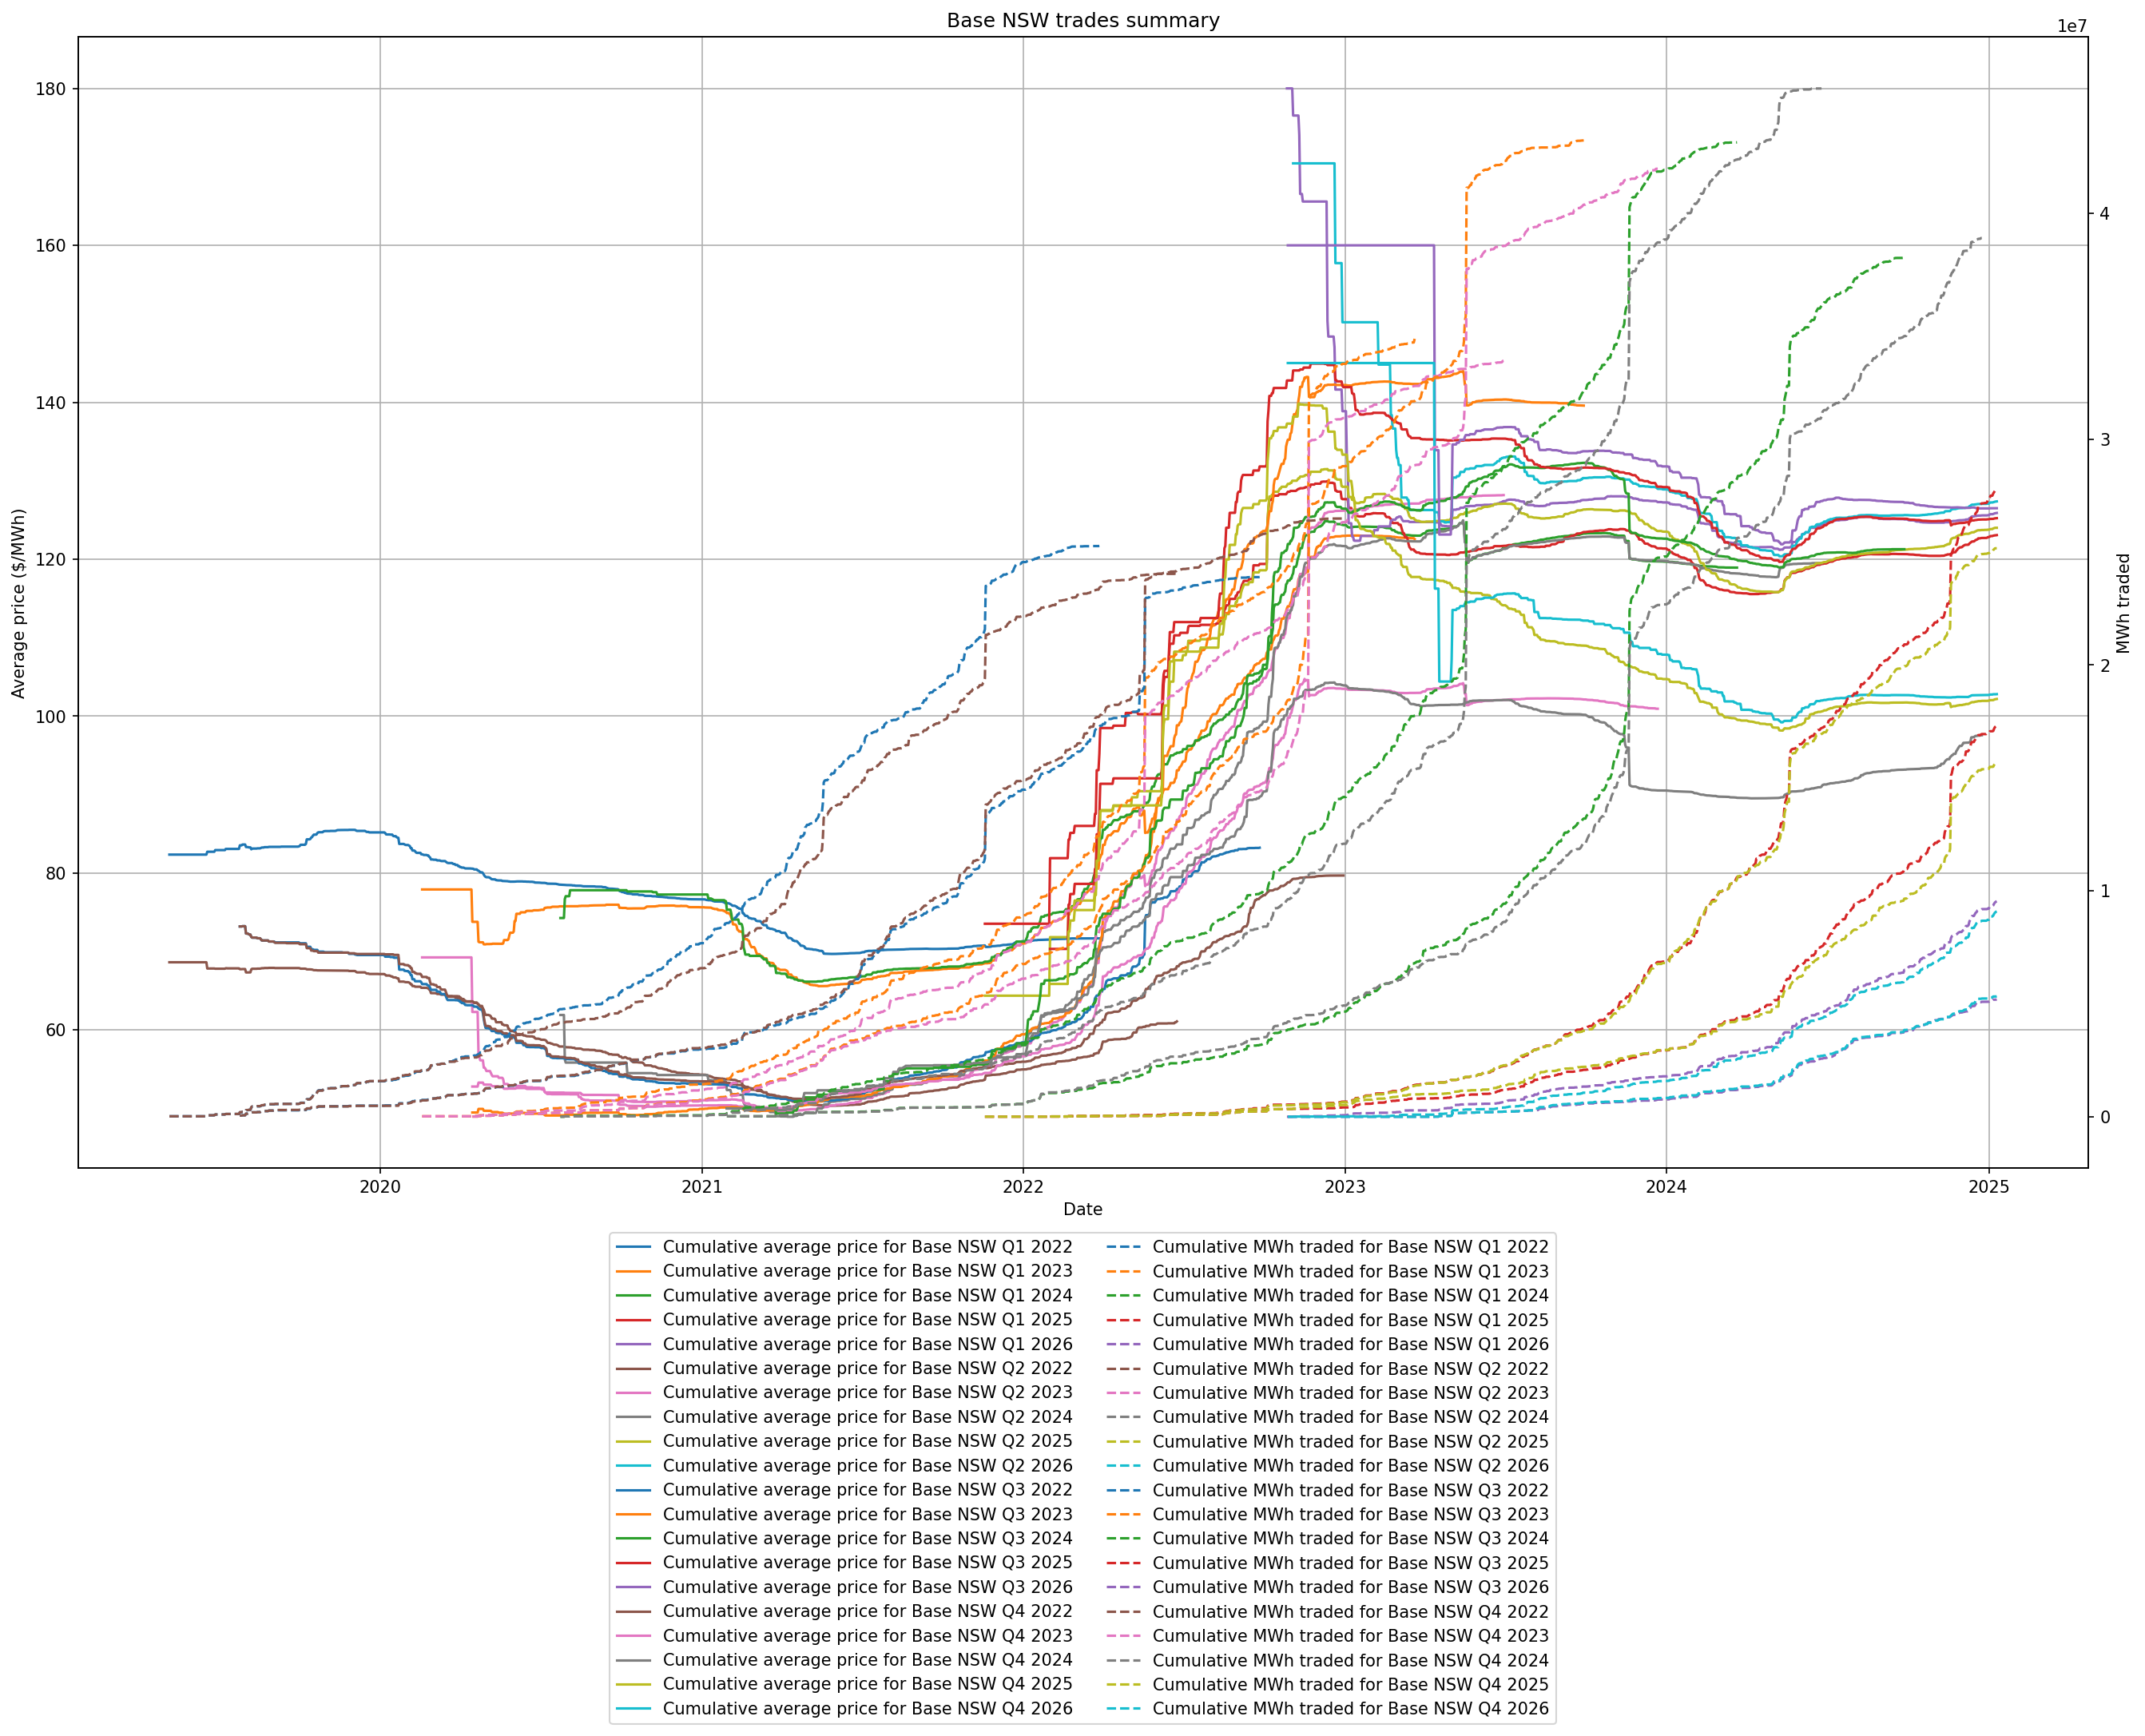

In [16]:
summary_title = f"{contract} {state} trades summary"
summary_df.to_csv(f'summary/{summary_title}.csv')
plot_summary_df(summary_df, summary_title)

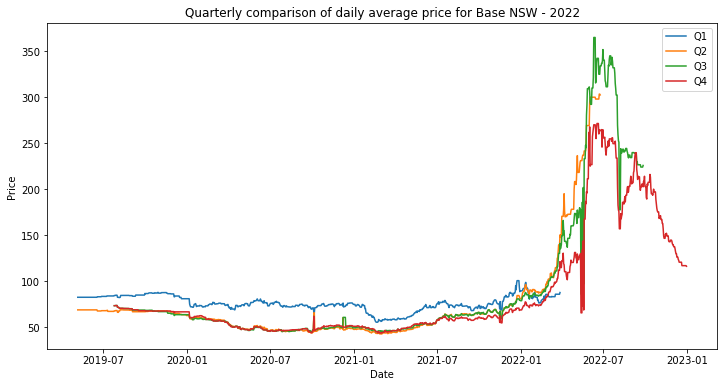

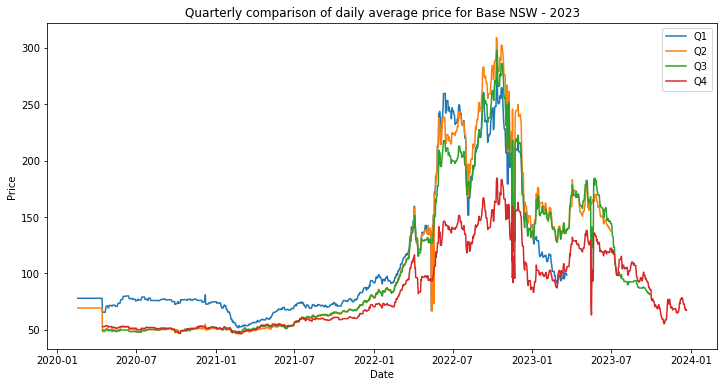

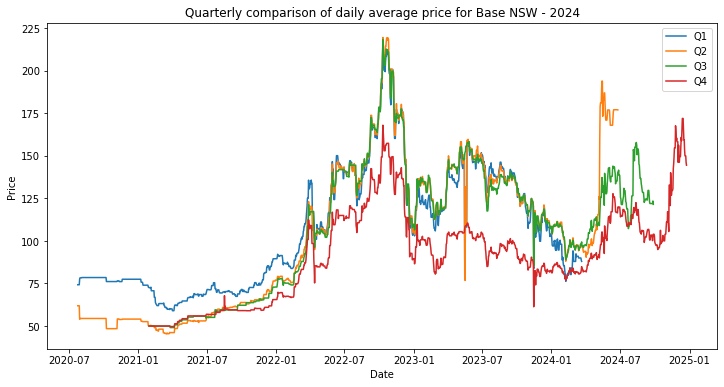

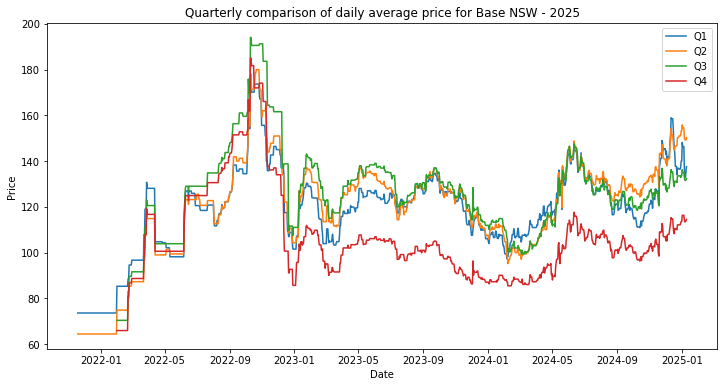

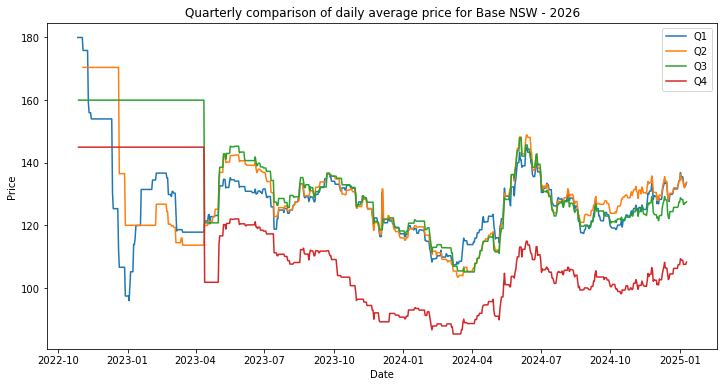

In [21]:
# Compare quarterly results within the same year

def quarterly_comparison_within_same_year(df, column_prefix, title_prefix):
    years = ['2022', '2023', '2024', '2025', '2026']
    
    for year in years:
        plt.figure(figsize=(12, 6))
        for quarter in ['Q1', 'Q2', 'Q3', 'Q4']:
            column_name = f'{column_prefix} {quarter} {year}'
            if column_name in df.columns:
                plt.plot(df['Date'], df[column_name], label=f'{quarter}')
        
        plt.title(f'Quarterly comparison of daily average price for {contract} {state} - {year}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

# Year-over-Year comparison for Daily average price for Base NSW
quarterly_comparison_within_same_year(summary_df, f'Daily average price for {contract} {state}', f'Year-over-Year Comparison of Daily Average Price for {contract} {state}')

In [61]:
# Master function with user input
'''
def plot_comparison(df, data_types, states, contract_types, quarters, years):
    for data_type in data_types:
        for state in states:
            for contract_type in contract_types:
                for quarter in quarters:
                    plt.figure(figsize=(12, 6))
                    for year in years:
                        column_name = f'{data_type} for {contract_type} {state} {quarter} {year}'
                        if column_name in df.columns:
                            plt.plot(df['Date'], df[column_name], label=f'{year}')
                
                    plt.title(f'{data_type} - {state} {contract_type} {quarter}')
                    plt.xlabel('Date')
                    plt.ylabel('Price')
                    plt.legend()
                    plt.show()

# Interactive widgets
data_type_widget = widgets.SelectMultiple(options=['Daily average price', 'Cumulative average price', 'Daily MWh traded', 'Cumulative MWh traded'], description='Data types')
state_widget = widgets.SelectMultiple(options=['NSW', 'VIC', 'QLD', 'SA', 'TAS'], description='States')
contract_type_widget = widgets.SelectMultiple(options=['Base', 'Peak', 'Cap'], description='Contract types')
quarter_widget = widgets.SelectMultiple(options=['Q1', 'Q2', 'Q3', 'Q4'], description='Quarters')
year_widget = widgets.SelectMultiple(options=['2022', '2023', '2024', '2025', '2026'], description='Years')

# Display widgets
display(data_type_widget, state_widget, contract_type_widget, quarter_widget, year_widget)

# Button to trigger the plot
button = widgets.Button(description="Plot Comparison")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        plot_comparison(summary_df, data_type_widget.value, state_widget.value, contract_type_widget.value, quarter_widget.value, year_widget.value)

button.on_click(on_button_clicked)
display(button, output)
'''

'\ndef plot_comparison(df, data_types, states, contract_types, quarters, years):\n    for data_type in data_types:\n        for state in states:\n            for contract_type in contract_types:\n                for quarter in quarters:\n                    plt.figure(figsize=(12, 6))\n                    for year in years:\n                        column_name = f\'{data_type} for {contract_type} {state} {quarter} {year}\'\n                        if column_name in df.columns:\n                            plt.plot(df[\'Date\'], df[column_name], label=f\'{year}\')\n                \n                    plt.title(f\'{data_type} - {state} {contract_type} {quarter}\')\n                    plt.xlabel(\'Date\')\n                    plt.ylabel(\'Price\')\n                    plt.legend()\n                    plt.show()\n\n# Interactive widgets\ndata_type_widget = widgets.SelectMultiple(options=[\'Daily average price\', \'Cumulative average price\', \'Daily MWh traded\', \'Cumulative MWh trade

In [55]:
def plot_comparison_by_quarter(df, data_types, states, contract_types, quarters, years):
    for state in states:
        for contract_type in contract_types:
            for year in years:
                fig, ax1 = plt.subplots(figsize=(18, 16), dpi=150)
                
                # Determine the type of plot based on data_types
                contains_price = any(dt in ['Daily average price', 'Cumulative average price'] for dt in data_types)
                contains_mwh = any(dt in ['Daily MWh traded', 'Cumulative MWh traded'] for dt in data_types)
                
                if contains_price and contains_mwh:
                    ax2 = ax1.twinx()
                else:
                    ax2 = None
                
                for quarter in quarters:
                    for dt in data_types:
                        column_name = f'{dt} for {contract_type} {state} {quarter} {year}'
                        if column_name in df.columns:
                            if dt in ['Daily average price', 'Cumulative average price']:
                                ax1.plot(df['Date'], df[column_name], label=f'{quarter} - {dt}')
                            elif dt in ['Daily MWh traded', 'Cumulative MWh traded']:
                                if ax2:
                                    ax2.plot(df['Date'], df[column_name], label=f'{quarter} - {dt}', linestyle='--')
                                else:
                                    ax1.plot(df['Date'], df[column_name], label=f'{quarter} - {dt}')
                
                ax1.set_title(f'{state} {contract_type} {year} trades summary')
                ax1.set_xlabel('Date')
                
                if contains_price:
                    ax1.set_ylabel('Average price ($/MWh)')
                if contains_mwh and ax2:
                    ax2.set_ylabel('MWh traded')
                elif contains_mwh:
                    ax1.set_ylabel('MWh traded')
                
                lines, labels = ax1.get_legend_handles_labels()
                if ax2:
                    lines2, labels2 = ax2.get_legend_handles_labels()
                    lines += lines2
                    labels += labels2
                ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()

In [56]:
def plot_comparison_by_year(df, data_types, states, contract_types, quarters, years):
    for state in states:
        for contract_type in contract_types:
            for quarter in quarters:
                fig, ax1 = plt.subplots(figsize=(18, 16), dpi=150)
                
                # Determine the type of plot based on data_types
                contains_price = any(dt in ['Daily average price', 'Cumulative average price'] for dt in data_types)
                contains_mwh = any(dt in ['Daily MWh traded', 'Cumulative MWh traded'] for dt in data_types)
                
                if contains_price and contains_mwh:
                    ax2 = ax1.twinx()
                else:
                    ax2 = None
                
                for year in years:
                    for dt in data_types:
                        column_name = f'{dt} for {contract_type} {state} {quarter} {year}'
                        if column_name in df.columns:
                            if dt in ['Daily average price', 'Cumulative average price']:
                                ax1.plot(df['Date'], df[column_name], label=f'{year} - {dt}')
                            elif dt in ['Daily MWh traded', 'Cumulative MWh traded']:
                                if ax2:
                                    ax2.plot(df['Date'], df[column_name], label=f'{year} - {dt}', linestyle='--')
                                else:
                                    ax1.plot(df['Date'], df[column_name], label=f'{year} - {dt}')
                
                ax1.set_title(f'{state} {contract_type} {quarter} trades summary')
                ax1.set_xlabel('Date')
                
                if contains_price:
                    ax1.set_ylabel('Average price ($/MWh)')
                if contains_mwh and ax2:
                    ax2.set_ylabel('MWh traded')
                elif contains_mwh:
                    ax1.set_ylabel('MWh traded')
                
                lines, labels = ax1.get_legend_handles_labels()
                if ax2:
                    lines2, labels2 = ax2.get_legend_handles_labels()
                    lines += lines2
                    labels += labels2
                ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()

In [54]:
def plot_comparison_by_state(df, data_types, states, contract_types, quarters, years):
    for contract_type in contract_types:
        for year in years:
            for quarter in quarters:
                fig, ax1 = plt.subplots(figsize=(18, 16), dpi=150)
                
                # Determine the type of plot based on data_types
                contains_price = any(dt in ['Daily average price', 'Cumulative average price'] for dt in data_types)
                contains_mwh = any(dt in ['Daily MWh traded', 'Cumulative MWh traded'] for dt in data_types)
                
                if contains_price and contains_mwh:
                    ax2 = ax1.twinx()
                else:
                    ax2 = None
                
                for state in states:
                    for dt in data_types:
                        column_name = f'{dt} for {contract_type} {state} {quarter} {year}'
                        if column_name in df.columns:
                            if dt in ['Daily average price', 'Cumulative average price']:
                                ax1.plot(df['Date'], df[column_name], label=f'{state} - {dt}')
                            elif dt in ['Daily MWh traded', 'Cumulative MWh traded']:
                                if ax2:
                                    ax2.plot(df['Date'], df[column_name], label=f'{state} - {dt}', linestyle='--')
                                else:
                                    ax1.plot(df['Date'], df[column_name], label=f'{state} - {dt}')
                
                ax1.set_title(f'{contract_type} {year} {quarter} trades summary')
                ax1.set_xlabel('Date')
                
                if contains_price:
                    ax1.set_ylabel('Average price ($/MWh)')
                if contains_mwh and ax2:
                    ax2.set_ylabel('MWh traded')
                elif contains_mwh:
                    ax1.set_ylabel('MWh traded')
                
                lines, labels = ax1.get_legend_handles_labels()
                if ax2:
                    lines2, labels2 = ax2.get_legend_handles_labels()
                    lines += lines2
                    labels += labels2
                ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()

In [57]:
def plot_comparison_by_contract_type(df, data_types, states, contract_types, quarters, years):
    for state in states:
        for year in years:
            for quarter in quarters:
                fig, ax1 = plt.subplots(figsize=(18, 16), dpi=150)
                
                # Determine the type of plot based on data_types
                contains_price = any(dt in ['Daily average price', 'Cumulative average price'] for dt in data_types)
                contains_mwh = any(dt in ['Daily MWh traded', 'Cumulative MWh traded'] for dt in data_types)
                
                if contains_price and contains_mwh:
                    ax2 = ax1.twinx()
                else:
                    ax2 = None
                
                for contract_type in contract_types:
                    for dt in data_types:
                        column_name = f'{dt} for {contract_type} {state} {quarter} {year}'
                        if column_name in df.columns:
                            if dt in ['Daily average price', 'Cumulative average price']:
                                ax1.plot(df['Date'], df[column_name], label=f'{contract_type} - {dt}')
                            elif dt in ['Daily MWh traded', 'Cumulative MWh traded']:
                                if ax2:
                                    ax2.plot(df['Date'], df[column_name], label=f'{contract_type} - {dt}', linestyle='--')
                                else:
                                    ax1.plot(df['Date'], df[column_name], label=f'{contract_type} - {dt}')
                
                ax1.set_title(f'{state} {year} {quarter} trades summary')
                ax1.set_xlabel('Date')
                
                if contains_price:
                    ax1.set_ylabel('Average price ($/MWh)')
                if contains_mwh and ax2:
                    ax2.set_ylabel('MWh traded')
                elif contains_mwh:
                    ax1.set_ylabel('MWh traded')
                
                lines, labels = ax1.get_legend_handles_labels()
                if ax2:
                    lines2, labels2 = ax2.get_legend_handles_labels()
                    lines += lines2
                    labels += labels2
                ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()

In [58]:
# Adjusted function to compare data by user-selected criteria and display multiple data types in the same chart
def plot_comparison(df, data_types, states, contract_types, quarters, years, compare_by):
    if compare_by == 'Quarter':
        plot_comparison_by_quarter(df, data_types, states, contract_types, quarters, years)
    elif compare_by == 'Year':
        plot_comparison_by_year(df, data_types, states, contract_types, quarters, years)
    elif compare_by == 'State':
        plot_comparison_by_state(df, data_types, states, contract_types, quarters, years)
    elif compare_by == 'Contract Type':
        plot_comparison_by_contract_type(df, data_types, states, contract_types, quarters, years)

# Interactive widgets
data_type_widget = widgets.SelectMultiple(options=['Daily average price', 'Cumulative average price', 'Daily MWh traded', 'Cumulative MWh traded'], description='Data types')
state_widget = widgets.SelectMultiple(options=['NSW', 'VIC', 'QLD', 'SA', 'TAS'], description='States')
contract_type_widget = widgets.SelectMultiple(options=['Base', 'Peak', 'Cap'], description='Contract types')
quarter_widget = widgets.SelectMultiple(options=['Q1', 'Q2', 'Q3', 'Q4'], description='Quarters')
year_widget = widgets.SelectMultiple(options=['2022', '2023', '2024', '2025', '2026'], description='Years')
compare_by_widget = widgets.RadioButtons(options=['Quarter', 'Year', 'State', 'Contract Type'], description='Compare by')

# Display widgets
display(data_type_widget, state_widget, contract_type_widget, quarter_widget, year_widget, compare_by_widget)

# Button to trigger the plot
button = widgets.Button(description="Plot Comparison")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        plot_comparison(summary_df, data_type_widget.value, state_widget.value, contract_type_widget.value, quarter_widget.value, year_widget.value, compare_by_widget.value)

button.on_click(on_button_clicked)
display(button, output)

SelectMultiple(description='Data types', options=('Daily average price', 'Cumulative average price', 'Daily MW…

SelectMultiple(description='States', options=('NSW', 'VIC', 'QLD', 'SA', 'TAS'), value=())

SelectMultiple(description='Contract types', options=('Base', 'Peak', 'Cap'), value=())

SelectMultiple(description='Quarters', options=('Q1', 'Q2', 'Q3', 'Q4'), value=())

SelectMultiple(description='Years', options=('2022', '2023', '2024', '2025', '2026'), value=())

RadioButtons(description='Compare by', options=('Quarter', 'Year', 'State', 'Contract Type'), value='Quarter')

Button(description='Plot Comparison', style=ButtonStyle())

Output()

In [60]:
!jupyter nbconvert --to script ASX_electricity_contract_price_and_volume_visualisation.ipynb

[NbConvertApp] Converting notebook ASX_electricity_contract_price_and_volume_visualisation.ipynb to script
[NbConvertApp] Writing 25726 bytes to ASX_electricity_contract_price_and_volume_visualisation.py
